##  Dataset Info
describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. 

It contains 100836 ratings and 3683 tag applications across 9742 movies.

These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

In [1]:
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get The Data

In [2]:
DATA_PATH="./Datasets/"

movies_df = pd.read_csv(os.path.join(DATA_PATH,"movies.csv"),usecols=['movieId','title'],dtype={'movieId': 'int32', 'title': 'str'})
rating_df=pd.read_csv(os.path.join(DATA_PATH,"ratings.csv"),usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
data=pd.merge(rating_df,movies_df,on='movieId')
data.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
 3   title    100836 non-null  object 
dtypes: float32(1), int32(2), object(1)
memory usage: 2.7+ MB


In [7]:
data=data.dropna(axis = 0, subset = ['title'])

In [8]:
movie_ratingCount=pd.DataFrame(data.title.value_counts()).reset_index()
movie_ratingCount.rename(columns={'index':'title','title':'totalRatingCount'},inplace=True)

In [9]:
data_w_TotalRating=data.merge(movie_ratingCount,on='title')
data_w_TotalRating.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [10]:
data_w_TotalRating['totalRatingCount'].describe().T

count    100836.000000
mean         58.758777
std          61.965384
min           1.000000
25%          13.000000
50%          39.000000
75%          84.000000
max         329.000000
Name: totalRatingCount, dtype: float64

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


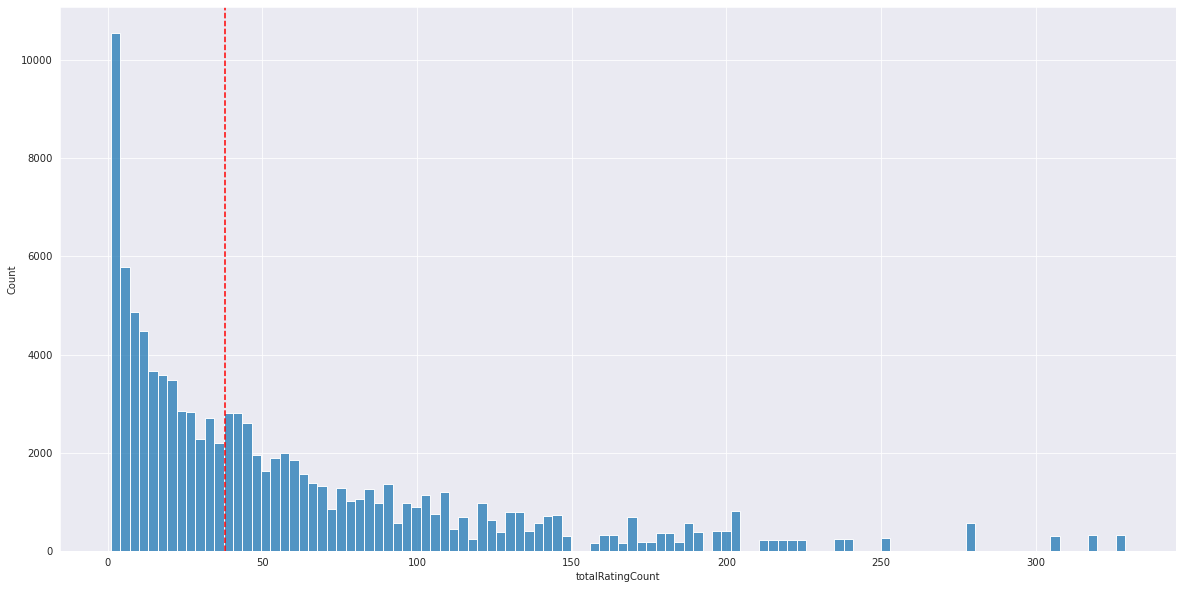

In [12]:
#data_w_TotalRating['totalRatingCount'].hist(bins=20);
plt.figure(figsize=(20,10))
sns.histplot(data_w_TotalRating['totalRatingCount'])
plt.axvline(38, 0, 1,c='r',ls='--')
plt.show()

In [13]:
popular_movies=data_w_TotalRating[data_w_TotalRating.totalRatingCount>=38]

In [14]:
popular_movies['totalRatingCount'].describe()

count    51560.000000
mean       100.761792
std         61.569359
min         38.000000
25%         54.000000
50%         81.000000
75%        129.000000
max        329.000000
Name: totalRatingCount, dtype: float64

## --------------------------------------------------------------------------------------------------------------------------------


In [15]:
from scipy.sparse import csc_matrix
from sklearn.neighbors import NearestNeighbors

# Looking for similar  movies

In [16]:
featuesOfMovies=popular_movies.pivot_table(index='title',columns='userId',values='rating').fillna(0)

In [17]:
featuesOfMovies_matrix=csc_matrix(featuesOfMovies.values)

In [18]:
model_4_movies=NearestNeighbors(metric='cosine',algorithm='brute')
model_4_movies.fit(featuesOfMovies_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [19]:
# chooseing random movie to see the similarty
random_index=np.random.choice(featuesOfMovies.shape[0])
distance,indices=model_4_movies.kneighbors(featuesOfMovies.iloc[random_index,:].values.reshape(1,-1),n_neighbors=5)


Dict=dict(zip(indices.flatten(),distance.flatten()))

# Print similer movies
print("Recommendation for who saw movies: ",featuesOfMovies.index[random_index],"\n")
for i,d in Dict.items():
    if featuesOfMovies.index[random_index] == featuesOfMovies.index[i]:
        pass
    else:
        print("{0}: similar to the movie with {1} %".format(featuesOfMovies.index[i],round(d*100,2)))


Recommendation for who saw movies:  Taken (2008) 

Bourne Ultimatum, The (2007): similar to the movie with 46.02 %
Casino Royale (2006): similar to the movie with 46.14 %
Blood Diamond (2006): similar to the movie with 48.29 %
Hangover, The (2009): similar to the movie with 48.84 %


In [20]:
print("Recommendation for who saw movies: ",featuesOfMovies.index[random_index],"\n")
for i,d in Dict.items():
    if featuesOfMovies.index[random_index] == featuesOfMovies.index[i]:
        pass
    else:
        print("{0}: similar to the movie with {1}%".format(featuesOfMovies.index[i],round(d*100,2)))


Recommendation for who saw movies:  Taken (2008) 

Bourne Ultimatum, The (2007): similar to the movie with 46.02%
Casino Royale (2006): similar to the movie with 46.14%
Blood Diamond (2006): similar to the movie with 48.29%
Hangover, The (2009): similar to the movie with 48.84%


## --------------------------------------------------------------------------------------------------------------------------------


# Looking for users haveing similar  taste

In [21]:
featuesOfUsers=popular_movies.pivot_table(index='userId',columns='title',values='rating').fillna(0)
featuesOfUsers_matrix=csc_matrix(featuesOfUsers.values)
model_4_users=NearestNeighbors(metric='cosine',algorithm='brute')
model_4_users.fit(featuesOfUsers_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [22]:
# chooseing random movie to see the similarty
random_index=np.random.choice(featuesOfUsers.shape[0])
distance,indices=model_4_users.kneighbors(featuesOfUsers.iloc[random_index,:].values.reshape(1,-1),n_neighbors=5)


Dict=dict(zip(indices.flatten(),distance.flatten()))

# Print similer movies
print("User: ",featuesOfUsers.index[random_index],"\n")
for i,d in Dict.items():
    if featuesOfUsers.index[random_index] == featuesOfUsers.index[i]:
        pass
    else:
        print("User {0} have similer test with {1}%".format(featuesOfUsers.index[i],round(d*100,2)))


User:  300 

User 443 have similer test with 49.87%
User 296 have similer test with 51.18%
User 497 have similer test with 51.4%
User 581 have similer test with 53.5%
